In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from mosestokenizer import *

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import Tensor, keras
import tensorflow_hub as hub
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dropout, Layer
from tensorflow.keras.layers import Embedding, Input, GlobalAveragePooling1D, Dense, TextVectorization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

In [3]:
df = pd.read_csv('../preprocessed_text/unprocessed_train.csv').sample(frac=1)
df_test = pd.read_csv('../preprocessed_text/unprocessed_test.csv')

X_train_text = df['Text']
X_test_text = df_test['Text']
y_train_categories = df['Verdict']
y_test_categories = df_test['Verdict']

# Data Analysis

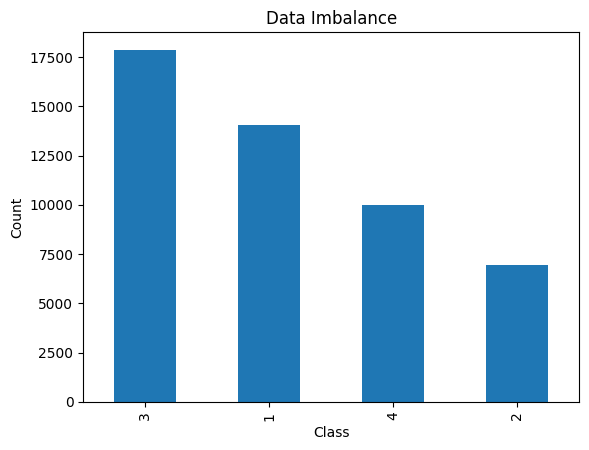

In [4]:
# Count the occurrences of each unique value in y_train
value_counts = y_train_categories.value_counts()

# Plot the data imbalance in a bar chart
value_counts.plot(kind='bar')

# Add labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Data Imbalance')

# Display the bar chart
plt.show()

In [5]:
df.head()

,Verdict,Text,Preprocessed Text
10472,1,"According to a new State Department report, Af...","According to a new State Department report, Af..."
24714,3,"Obey = Slavery, Disobey = FreedomBy David Icke...","Obey = Slavery, Disobey = FreedomBy David Icke..."
48682,4,The opposition Democratic Progressive Party (D...,The opposition Democratic Progressive Party (D...
46514,4,The spokesman of Iran's Aviation Organization ...,The spokesman of Iran's Aviation Organization ...
42386,4,"2009, The Washington Post WASHINGTON -- What d...","2009, The Washington Post WASHINGTON -- What d..."


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48854 entries, 10472 to 15716
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Verdict            48854 non-null  int64 
 1   Text               48854 non-null  object
 2   Preprocessed Text  48854 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


# Preprocess text

In [7]:
def lowercase(text: Tensor) -> Tensor:
  return tf.strings.lower(text)

def remove_numbers(text: Tensor) -> Tensor:
  return tf.strings.regex_replace(text, '[0-9]', '')

def remove_punctuations(text: Tensor) -> Tensor:
  return tf.strings.regex_replace(text, '[%s]' % re.escape('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'), '')

def preprocess_text(text: Tensor) -> Tensor:
  text = lowercase(text)
  text = remove_numbers(text)
  text = remove_punctuations(text)
  return text

# Vectorize layer

In [8]:
vocab_size = 10000
max_length = 128

In [9]:
vectorize_layer = TextVectorization(
    standardize=preprocess_text,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length,
  )

2024-04-12 14:27:11.947484: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14392 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:19:00.0, compute capability: 8.6
2024-04-12 14:27:11.947990: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14392 MB memory:  -> device: 1, name: NVIDIA RTX A4000, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-04-12 14:27:11.948385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14392 MB memory:  -> device: 2, name: NVIDIA RTX A4000, pci bus id: 0000:67:00.0, compute capability: 8.6
2024-04-12 14:27:11.948737: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 14323 MB memory:  -> device: 3, name: NVIDIA RTX A4000, pci bus id: 0000:68:00.0, 

In [10]:
vectorize_layer.adapt(X_train_text.to_list())

In [11]:
vectorize_layer.vocabulary_size()

10000

In [12]:
vectorize_layer(X_train_text[0])

<tf.Tensor: shape=(128,), dtype=int64, numpy=
array([   6,  227,  309,   68,    6, 1446,  354, 5761, 1347,   49, 7786,
         14,    6,    1,    4, 1078,  134,  501,   36,   11,  670,  351,
        533,    8,   10,    2, 7491, 5268,  108, 8671, 1069,   19,   48,
       3802,   51,   14,  112,    1, 1857,    4,   30, 1068,    7, 3104,
         12,  524,   64,   59, 2269, 2545, 1154, 3697,    5,   32, 8472,
       5692,   49, 2651,    2, 5457, 1974,  252,  267, 5761, 1771,    5,
          1, 6157, 1905, 5400,    1,   29, 1418,  191,  140, 2733,    2,
        101, 1579,   47,  200,  549,    5, 1307,   30, 1068,   36,  191,
       1272,    3,  104, 1963,  169,    1, 5761, 2194, 7609, 1963,   36,
        448, 5400,  847,  140,  523,    3, 2681,   30, 4851,    1,  441,
       4417,   19,  888,    8,   53, 4852, 3052,   58,    1,    2, 8671,
         33,  436,    2,  558,  991, 1679,    4])>

# Model components

In [13]:
class TransformerBlock(Layer):
  def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
    super(TransformerBlock, self).__init__()
    self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
    self.ffn = Sequential(
        [Dense(ff_dim, activation="relu"), 
          Dense(embed_dim),]
    )
    self.layernorm1 = LayerNormalization(epsilon=1e-6)
    self.layernorm2 = LayerNormalization(epsilon=1e-6)
    self.dropout1 = Dropout(rate)
    self.dropout2 = Dropout(rate)

  def call(self, inputs, training=False):
    attn_output = self.att(inputs, inputs)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(inputs + attn_output)
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    return self.layernorm2(out1 + ffn_output)

In [14]:
class TokenAndPositionEmbedding(Layer):
  def __init__(self, maxlen, vocab_size, embed_dim):
    super(TokenAndPositionEmbedding, self).__init__()
    self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
    self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

  def call(self, x):
    maxlen = tf.shape(x)[-1]
    positions = tf.range(start=0, limit=maxlen, delta=1)
    positions = self.pos_emb(positions)
    x = self.token_emb(x)
    return x + positions

# Base transformer

In [15]:
vocab_size = 10000  # Vocabulary size
max_length = 128  # Maximum length of token sequence
embed_dim = 100  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.1  # Dropout rate
hidden_units = 32  # Number of neurons in feed forward network
output_dim = 4  # Number of classes

inputs = Input(shape=(1,), dtype=tf.string)
x = vectorize_layer(inputs)
# inputs = Input(shape=(max_length,), dtype=tf.int64)
embedding_layer = TokenAndPositionEmbedding(max_length, vocab_size, embed_dim)
x = embedding_layer(x)
# x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x, training=True)
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
x = Dense(hidden_units, activation="relu")(x)
x = Dropout(dropout_rate)(x)
outputs1 = Dense(output_dim, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 128)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_and_position_embedding    │ (None, 128, 100)       │     1,012,800 │
│ (TokenAndPositionEmbedding)     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ (None, 128, 100)       │        87,632 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 100)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         3,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,103,796 (4.21 MB)

 Trainable params: 1,103,796 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

# Elmo

In [64]:
# preprocess data
def lowercase(text: str) -> str:
  return text.lower()

def remove_numbers(text: str) -> str:
  return re.sub(r'\d+', '', text)

def remove_punctuations(text: str) -> str:
  return re.sub(r'[^\w\s]', '', text)

def preprocess_text(text: str) -> str:
  text = lowercase(text)
  text = remove_numbers(text)
  text = remove_punctuations(text)
  return text

In [86]:
# tokenize data
tokenizer = MosesTokenizer()
padding_token = ''
max_length = 128

def tokenize_and_pad(text: str) -> list:
  tokens = tokenizer(text)
  tokens = tokens[:max_length]
  tokens += [padding_token] * (max_length - len(tokens))
  return tokens

In [88]:
# embed data
elmo_tfhub = "https://www.kaggle.com/models/google/elmo/TensorFlow1/elmo/3"
elmo_embed_dim = 1024
elmo_embed = hub.KerasLayer(elmo_tfhub, trainable=True, signature="tokens")

def embed_text(tokens):
  return elmo_embed(tokens)

In [89]:
X_train_text
X_test_text

def prepare_features(x):
  x = preprocess_text(x)
  x = tokenize_and_pad(x)
  x = elmo_embed(tf.constant(x))
  return x

y_train_zero_based = y_train_categories - 1
y_test_zero_based = y_test_categories - 1

y_train = to_categorical(y_train_zero_based, num_classes=output_dim)
y_test = to_categorical(y_test_zero_based, num_classes=output_dim)

def batch_generator(data, labels, batch_size=64):
    """Yield batches of data and labels"""
    batch_features = []
    batch_labels = []

    for x, y in zip(data, labels):
        batch_features.append(prepare_features(x))
        batch_labels.append(y)
        if len(batch_features) == batch_size:
            yield np.array(batch_features), np.array(batch_labels)
            batch_features = []
            batch_labels = []
    
    # Yield any remaining data as the last batch
    if batch_features:
        yield np.array(batch_features), np.array(batch_labels)

def train_generator(batch_size=64):
    return batch_generator(X_train_text, y_train, batch_size)

def test_generator(batch_size=64):
    return batch_generator(X_test_text, y_test, batch_size)


In [90]:
class ElmoEmbedding(Layer):
  elmo_tfhub = "https://www.kaggle.com/models/google/elmo/TensorFlow1/elmo/3"
  elmo_embed_dim = 1024
  accepted_length = 128

  def __init__(self, trainable=False):
    super(ElmoEmbedding, self).__init__()
    self.elmo_emb = hub.KerasLayer(self.elmo_tfhub, trainable=trainable)
  
  @tf.function(input_signature=[tf.TensorSpec(shape=[None, accepted_length], dtype=tf.string)])
  def call(self, x):
    elmo_embeddings = self.elmo_emb(x)
    return elmo_embeddings
  
  def compute_output_shape(self, input_shape):
    return (input_shape[0], self.accepted_length, self.elmo_embed_dim)

In [91]:
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.1  # Dropout rate
hidden_units = 32  # Number of neurons in feed forward network
output_dim = 4  # Number of classes
embed_dim = ElmoEmbedding.elmo_embed_dim  # Embedding size for elmo tokens

inputs = Input(shape=(None,elmo_embed_dim), dtype=tf.float32)
# embedding_layer = ElmoEmbedding(trainable=False)
# x = embedding_layer(inputs)
transformer_block = TransformerBlock(elmo_embed_dim, num_heads, ff_dim)
x = transformer_block(inputs, training=True)
x = GlobalAveragePooling1D()(x)
x = Dropout(dropout_rate)(x)
x = Dense(hidden_units, activation="relu")(x)
x = Dropout(dropout_rate)(x)
outputs1 = Dense(output_dim, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs1)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, None, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ (None, None, 1024)     │     8,466,464 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 32)             │        32,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,499,396 (32.42 MB)

 Trainable params: 8,499,396 (32.42 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
y_train_zero_based = y_train_categories - 1
y_test_zero_based = y_test_categories - 1

y_train = to_categorical(y_train_zero_based, num_classes=output_dim)
y_test = to_categorical(y_test_zero_based, num_classes=output_dim)

In [95]:
batch_size = 64  # Batch size for training
epochs = 5  # Number of complete passes through the dataset

model.fit(train_generator(), epochs=epochs, validation_data=test_generator())

ValueError: Exception encountered when calling layer 'keras_layer_46' (type KerasLayer).

Setting hub.KerasLayer.trainable = True is unsupported when loading from the TF1 Hub format.

Call arguments received by layer 'keras_layer_46' (type KerasLayer):
  • inputs=tf.Tensor(shape=(128,), dtype=string)
  • training=None

In [25]:
model.save('../models/elmo.keras')

# Model Scoring

In [26]:
model.evaluate(test_generator())

47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.4116 - loss: 1.6120


2024-04-12 15:04:48.781601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-04-12 15:04:48.781651: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/bizon/miniconda3/envs/project55/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-04-12 15:04:48.781709: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 2577497430302868104
2024-04-12 15:04:48.781753: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key has

[1.4178016185760498, 0.4866666793823242]

In [28]:
# Accuracy, Precision, Recall, F1 Score
y_pred = model.predict(train_generator())
y_pred = np.argmax(y_pred, axis=1)
y_true = y_train_zero_based
print(classification_report(y_true, y_pred))

    763/Unknown 911s 1s/step

I0000 00:00:1712906440.788555  141622 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_214', 240 bytes spill stores, 240 bytes spill loads



764/764 ━━━━━━━━━━━━━━━━━━━━ 913s 1s/step


2024-04-12 15:20:41.773171: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

           0       0.68      0.68      0.68     14047
           1       0.50      0.18      0.26      6942
           2       0.67      0.92      0.78     17870
           3       0.80      0.65      0.71      9995

    accuracy                           0.69     48854
   macro avg       0.66      0.60      0.61     48854
weighted avg       0.68      0.69      0.66     48854



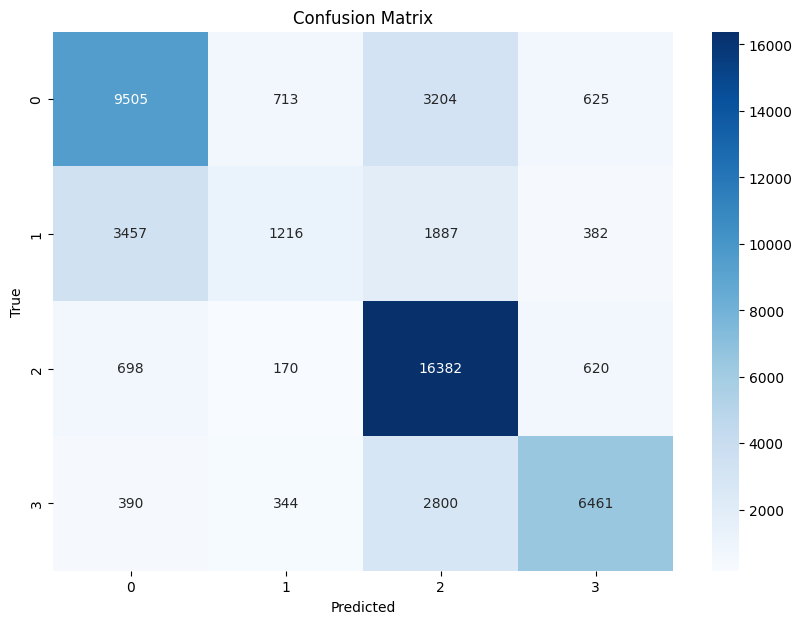

In [29]:
# Confusion matrix for Training Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Accuracy, Precision, Recall, F1 Score
y_pred = model.predict(test_generator())
y_pred = np.argmax(y_pred, axis=1)
y_true = y_test_zero_based
print(classification_report(y_true, y_pred))

47/47 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step
              precision    recall  f1-score   support

           0       0.56      0.44      0.49       750
           1       0.34      0.10      0.16       750
           2       0.41      0.91      0.57       750
           3       0.69      0.50      0.58       750

    accuracy                           0.49      3000
   macro avg       0.50      0.49      0.45      3000
weighted avg       0.50      0.49      0.45      3000



2024-04-12 15:21:38.906524: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/home/bizon/miniconda3/envs/project55/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


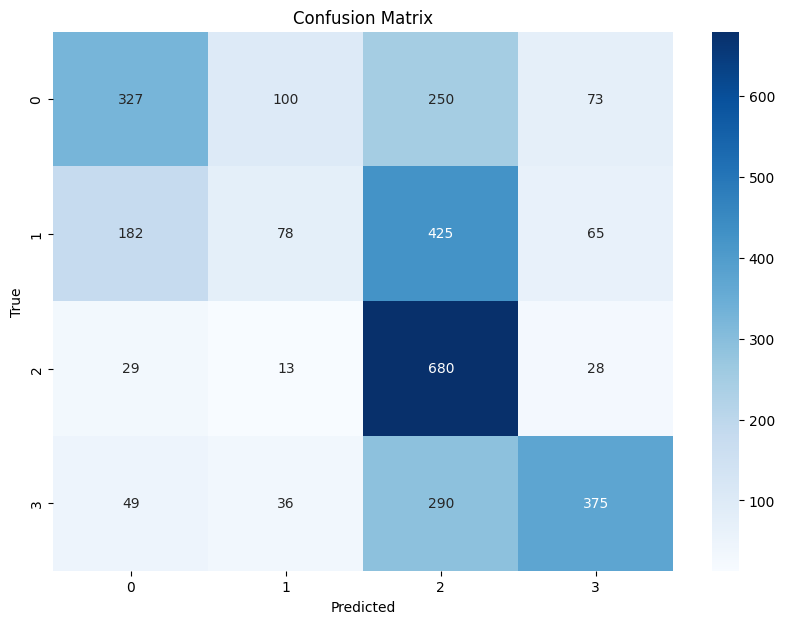

In [31]:
# Confusion matrix for Testing Data
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()